### Imported Libararies

In [1]:
# ===============================
# Data APIs
# ===============================
import yfinance as yf
from fredapi import Fred

# ===============================
# Core Data Processing
# ===============================
import numpy as np
import pandas as pd

# ===============================
# Visualization
# ===============================
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# ===============================
# Model Selection / CV Tools
# ===============================
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV,
    KFold
)

# ===============================
# Preprocessing
# ===============================
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ===============================
# Models
# ===============================
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# ===============================
# Class Weights
# ===============================
from sklearn.utils.class_weight import compute_class_weight

# ===============================
# Metrics & Evaluation
# ===============================
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)

# ===============================
# Model Interpretation
# ===============================
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

# ===============================
# Other lib
# ===============================
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from dotenv import load_dotenv
import os

ROOT = Path.cwd()  # or project root
from utilities import *


####################################
# Load environment variables from .env
load_dotenv()

# Access variables
fred_key = os.getenv("FRED_API_KEY")
fred = Fred(api_key=fred_key) # fred is an object - an instance of the `Fred` Class # can apply your own api_key on the website, quite easy

### Load data from the `./data/raw` fold

In [2]:
stage01_component02_data = pd.read_csv('./data/raw/stage01_component02_based_on_sp500_data.csv')
stage01_component02_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
stage01_component02_data['Date'] = pd.to_datetime(stage01_component02_data['Date'])
stage01_component02_data.set_index('Date', inplace=True)

In [3]:
stage01_component02_data

,financial_turbulence,nfc_risk,nfc_credit,nfc_leverage,TR CAPE,effr,t3m effr spread,sp_3m_drawdown,regime
Date,,,,,,,,,
2000-01-01,22.841074,-0.258570,0.058478,1.317603,47.587687,5.45,0.049000,-0.074249,1
2000-02-01,40.765227,-0.246968,0.025660,1.351058,45.807695,5.73,-0.003000,-0.092489,1
2000-03-01,24.338714,-0.155668,0.063858,1.181748,46.876009,5.85,0.013913,-0.077339,1
2000-04-01,17.526429,-0.033340,0.119385,0.876302,47.155407,6.02,-0.198421,-0.111885,1
2000-05-01,30.346908,0.061378,0.159085,0.602598,45.413038,6.27,-0.275455,-0.100559,1
...,...,...,...,...,...,...,...,...,...
2025-04-01,7.997304,-0.403042,0.017880,-0.419015,35.015341,4.33,-0.007619,-0.189022,2
2025-05-01,10.374257,-0.446606,-0.008484,-0.455824,37.637336,4.33,0.031429,-0.087890,1
2025-06-01,7.777923,-0.503590,-0.036160,-0.520180,38.732625,4.33,0.091000,-0.012807,0


# Stacking model to predict the market regime

In [4]:
# drop sp_3m_drawdown
df = stage01_component02_data.copy()
df['regime'] = df['regime'].shift(1)
df = df.dropna()

# merge the correction market regime with the bear correction market regime, and the reason are above
df.loc[df['regime'] == 2 , 'regime'] = 1

After the merge, the question become a binary classification. Therefore, we can use the ROC curve.

## Base Model 01: Random Forest

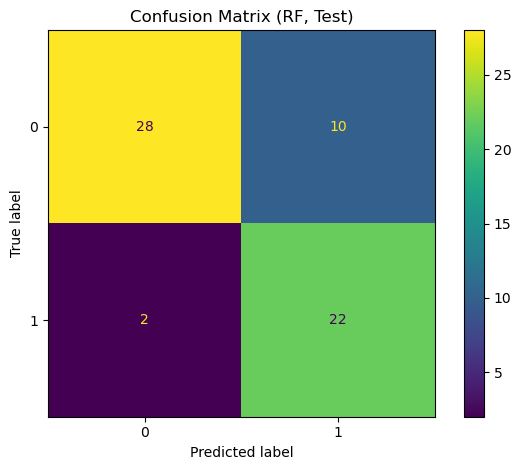

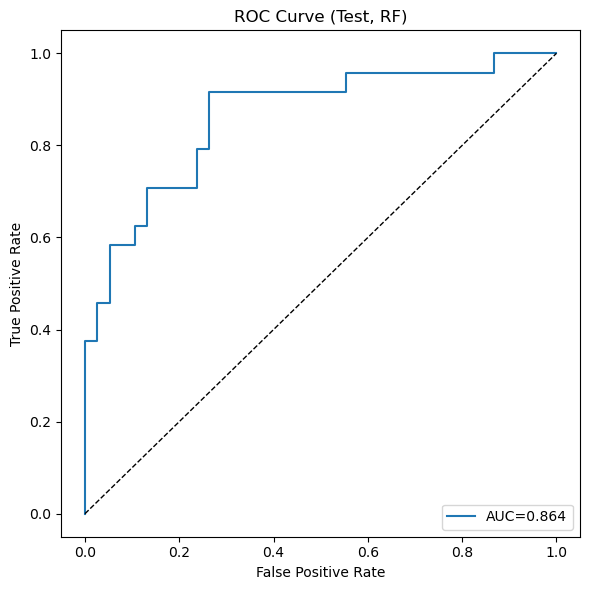

Best params: {'rf__bootstrap': True, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 600}
Best CV score (F1): 0.707963656090
Classification report (test):
         precision  recall  f1-score  support
      0  0.933  0.737  0.824      38
      1  0.688  0.917  0.786      24
accuracy                0.806      62
macro avg  0.810  0.827  0.805      62
weighted avg  0.838  0.806  0.809      62

Head of prediction table:
            regime_actual  regime_pred  regime_prob1
Date                                                
2020-07-01              1            1      0.530339
2020-08-01              0            0      0.367611
2020-09-01              0            1      0.630206
2020-10-01              1            1      0.619023
2020-11-01              1            1      0.503753
RF best params: {'rf__bootstrap': True, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 600}
RF best CV score: 0.7

In [5]:
res_rf = train_rf_regime_classifier(
    df=df,
    target_col="regime",
    test_size=0.2,        # last 20% as test
    n_splits=5,           # TimeSeriesSplit folds
    scoring="f1_macro",   # use f1 for binary; f1_macro for multiclass
    tune=True,            # turn off to skip grid search
    plot=True             # show Confusion Matrix + ROC
)

print("RF best params:", res_rf["best_params"])
print("RF best CV score:", res_rf["best_cv_score"])
print(res_rf["report_text"])             # pretty-printed classification report
print(res_rf["pred_table"].head())       # standardized prediction table

# top features (Gini)
print(res_rf["gini_importances"].head(10))


## Base Model 02: Gaussian Naive Bayes

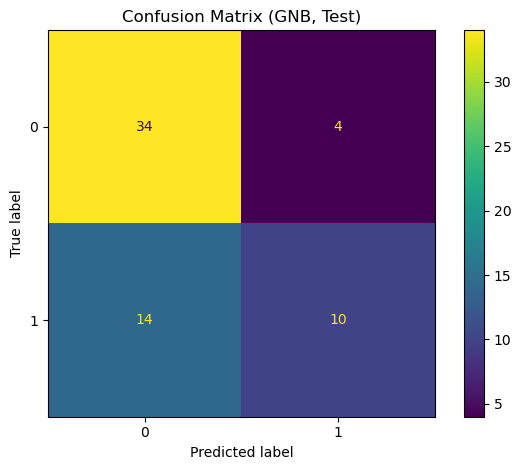

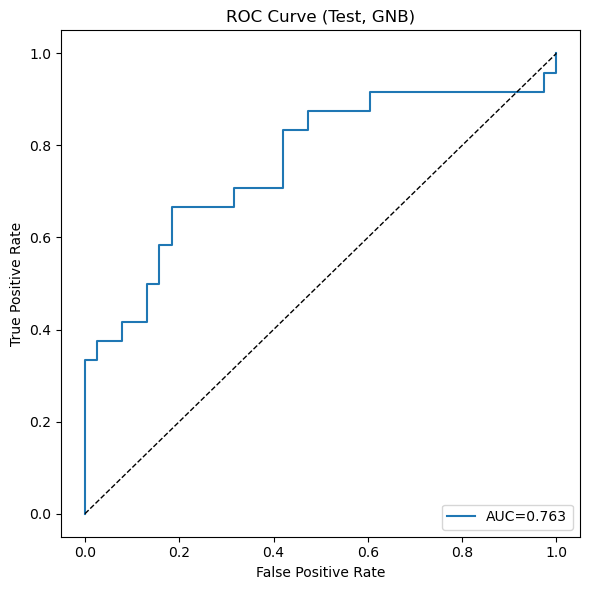

Best params: {'gnb__priors': None, 'gnb__var_smoothing': np.float64(1e-12)}
Best CV score (F1): 0.339649122807
Classification report (test):
         precision  recall  f1-score  support
      0  0.708  0.895  0.791      38
      1  0.714  0.417  0.526      24
accuracy                0.710      62
macro avg  0.711  0.656  0.659      62
weighted avg  0.711  0.710  0.688      62

Head of prediction table:
            regime_actual  regime_pred  regime_prob1
Date                                                
2020-07-01              1            0      0.002122
2020-08-01              0            0      0.003380
2020-09-01              0            0      0.104372
2020-10-01              1            0      0.014662
2020-11-01              1            0      0.376951
GNB best params: {'gnb__priors': None, 'gnb__var_smoothing': np.float64(1e-12)}
GNB best CV score: 0.33964912280701753
Classification report (test):
         precision  recall  f1-score  support
      0  0.708  0.895  0.79

In [6]:
# For STRICTLY binary, set scoring="f1" (or "roc_auc"); for multiclass use "f1_macro"
res_gnb = train_gnb_regime_classifier(
    df=df,
    target_col="regime",
    test_size=0.2,
    n_splits=5,
    scoring="f1",         # common choice for binary
    tune=True,
    plot=True
)

print("GNB best params:", res_gnb["best_params"])
print("GNB best CV score:", res_gnb["best_cv_score"])
print(res_gnb["report_text"])
print(res_gnb["pred_table"].head())      # has regime_actual, regime_pred, regime_prob1 (binary)


## Base Model 03: SVC with scaling

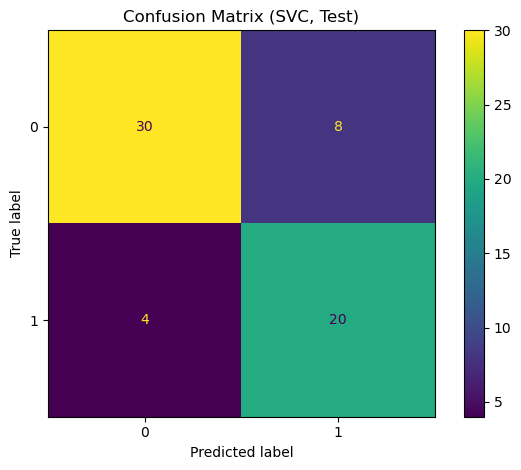

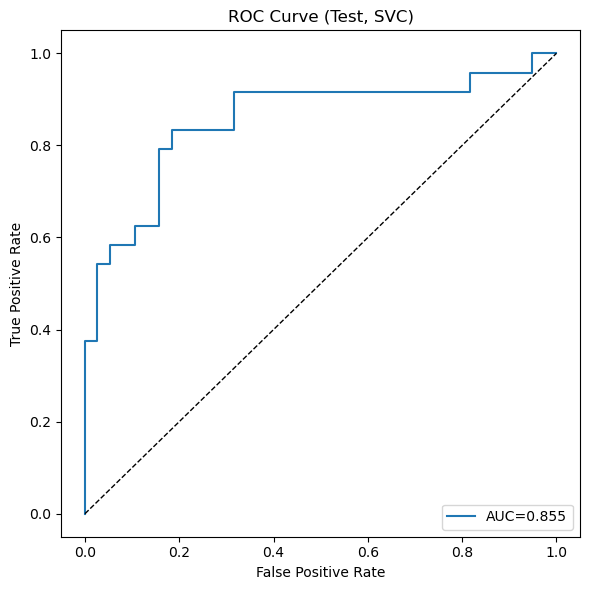

Best params: {'svc__C': 5, 'svc__kernel': 'linear'}
Best CV score (F1): 0.597089927616
Classification report (test):
         precision  recall  f1-score  support
      0  0.882  0.789  0.833      38
      1  0.714  0.833  0.769      24
accuracy                0.806      62
macro avg  0.798  0.811  0.801      62
weighted avg  0.817  0.806  0.809      62

Head of prediction table:
            regime_actual  regime_pred  regime_prob1
Date                                                
2020-07-01              1            0      0.252487
2020-08-01              0            0      0.135965
2020-09-01              0            1      0.480166
2020-10-01              1            1      0.393681
2020-11-01              1            1      0.385263
SVC best params: {'svc__C': 5, 'svc__kernel': 'linear'}
SVC best CV score: 0.5970899276162435
Classification report (test):
         precision  recall  f1-score  support
      0  0.882  0.789  0.833      38
      1  0.714  0.833  0.769      24
ac

In [7]:
res_svc = train_svc_regime_classifier(
    df=df,
    target_col="regime",
    test_size=0.2,
    n_splits=5,
    scoring="f1",       # "f1" or "roc_auc" for binary; "f1_macro" for multiclass
    tune=True,
    plot=True,
    random_state=42
)

print("SVC best params:", res_svc["best_params"])
print("SVC best CV score:", res_svc["best_cv_score"])
print(res_svc["report_text"])
print(res_svc["pred_table"].head())


## Stacking Model: Time-series-safe Stacking (RF + SVC + GNB → LR meta)

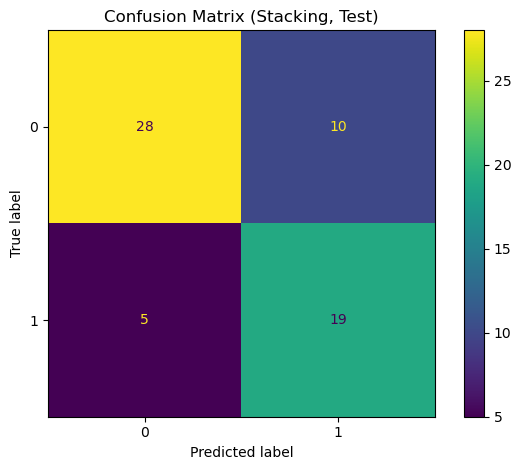

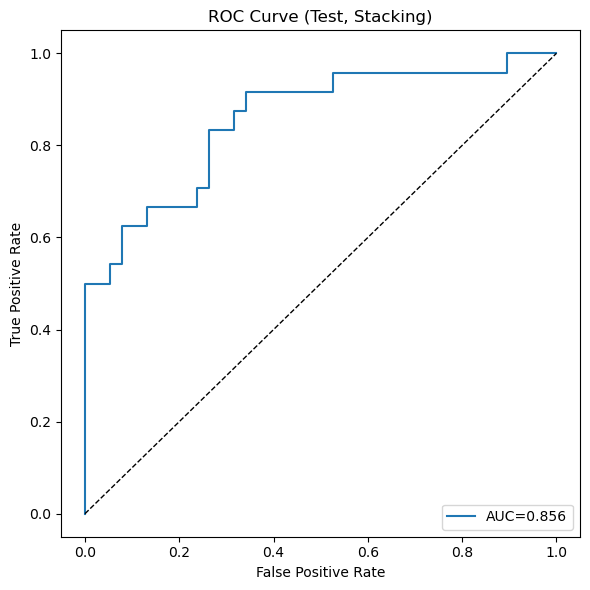

Best params: {'meta': {'C': 10}}
Best CV score (F1): 0.624613859946
Classification report (test):
         precision  recall  f1-score  support
      0  0.848  0.737  0.789      38
      1  0.655  0.792  0.717      24
accuracy                0.758      62
macro avg  0.752  0.764  0.753      62
weighted avg  0.774  0.758  0.761      62

Head of prediction table:
            regime_actual  regime_pred  regime_prob1
Date                                                
2020-07-01              1            1      0.510327
2020-08-01              0            0      0.266281
2020-09-01              0            1      0.527132
2020-10-01              1            0      0.493302
2020-11-01              1            0      0.441729
Stacking top-level best params: {'meta': {'C': 10}}
Stacking best CV score: 0.624613859946257
Classification report (test):
         precision  recall  f1-score  support
      0  0.848  0.737  0.789      38
      1  0.655  0.792  0.717      24
accuracy             

In [8]:
# Works for binary or multiclass. Uses forward-chaining OOF for meta features.
res_stack = train_ts_safe_stacking(
    df=df,
    target_col="regime",
    test_size=0.2,
    n_splits=5,
    random_state=42,
    scoring="f1_macro",     # good default (multiclass-safe)
    tune_base=True,         # tune RF/SVC/GNB on train via TSCV
    tune_meta=True,         # tune LR(C) on OOF features
    param_grids=None,       # or pass custom grids by keys: "rf","svc","gnb","meta"
    plot=True
)

print("Stacking top-level best params:", res_stack["best_params"])   # meta best if tuned
print("Stacking best CV score:", res_stack["best_cv_score"])
print(res_stack["report_text"])
print(res_stack["pred_table"].head())

# If you want each base learner's tuning details:
print(res_stack["tuned_info"])      # dict with RF/SVC/GNB best params & CVs (if tune_base=True)


Broader Hyper Parameter Tuning

In [9]:
# Bigger grids for RF / SVC / GNB / Meta (LogisticRegression)
large_param_grids = {
    "rf": {
        "rf__n_estimators": [100, 200, 300],
        "rf__max_depth": [None, 6, 8, 12, 16, 24, 32],
        "rf__min_samples_leaf": [1, 2, 3, 4, 5, 10],
        "rf__min_samples_split": [2, 5, 10],
        "rf__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
        "rf__bootstrap": [True],
    },
    "svc": {
        # degree/coef0 are always valid attrs; SVC will ignore them when irrelevant
        "svc__kernel": ["linear", "rbf", "poly", "sigmoid"],
        "svc__C": [0.01, 0.1, 1, 3, 10, 30],
        "svc__gamma": ["scale", "auto", 1e-3, 1e-2, 1e-1],
        "svc__degree": [2, 3, 4, 5],
        "svc__coef0": [0.0, 0.5, 1.0],
    },
    "gnb": {
        "gnb__var_smoothing": np.logspace(-13, -6, 8),
    },
    "meta": {
        "C": [0.01, 0.1, 0.5, 1, 2, 3, 5, 10, 20],
    },
}


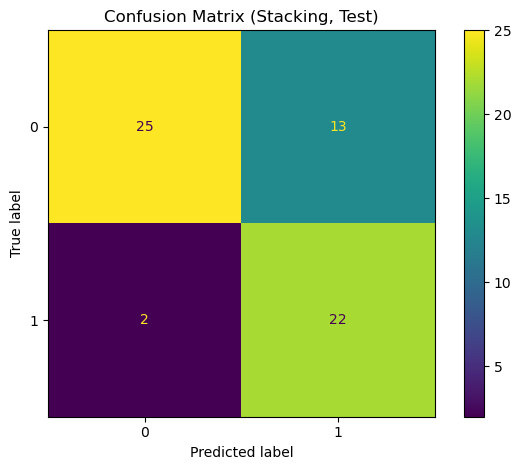

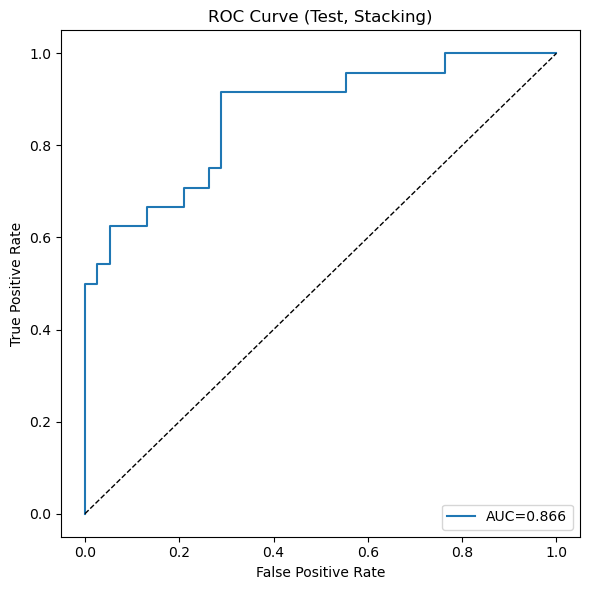

Best params: {'meta': {'C': 20}}
Best CV score (F1): 0.637045448248
Classification report (test):
         precision  recall  f1-score  support
      0  0.926  0.658  0.769      38
      1  0.629  0.917  0.746      24
accuracy                0.758      62
macro avg  0.777  0.787  0.757      62
weighted avg  0.811  0.758  0.760      62

Head of prediction table:
            regime_actual  regime_pred  regime_prob1
Date                                                
2020-07-01              1            1      0.542755
2020-08-01              0            0      0.344216
2020-09-01              0            1      0.648463
2020-10-01              1            1      0.623941
2020-11-01              1            1      0.525005
Top-level best params (meta): {'meta': {'C': 20}}
Top-level best CV score: 0.6370454482477659

Base learners' tuning info:
  rf: {'rf__bootstrap': True, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 10, 'rf__n_e

In [10]:
res_stack = train_ts_safe_stacking(
    df=df,
    target_col="regime",
    test_size=0.2,
    n_splits=5,
    random_state=42,
    scoring="f1_macro",        # good default; use "f1" for strictly binary if you prefer
    tune_base=True,            # tune RF/SVC/GNB on train via TimeSeriesSplit
    tune_meta=True,            # tune LR(C) on OOF features
    param_grids=large_param_grids,
    plot=True                  # show Confusion Matrix + ROC
)

# --- inspect results ---
print("Top-level best params (meta):", res_stack["best_params"])   # meta's best C if tuned
print("Top-level best CV score:", res_stack["best_cv_score"])      # CV on meta OOF
print("\nBase learners' tuning info:")
for name, info in res_stack["tuned_info"].items():
    print(f"  {name}: {info['best_params']}, CV={info['best_cv_score']:.6f}")

print("\nClassification report:\n", res_stack["report_text"])
print("\nPrediction table (head):")
print(res_stack["pred_table"].head())